In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


In [ ]:
!git clone https://github.com/jacobgil/vit-explain.git

Cloning into 'vit-explain'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 96 (delta 36), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
from IPython.display import clear_output
!pip3 install hub
clear_output()

In [ ]:
import hub
from PIL import Image
import numpy as np
import os, time
import torch
from torchvision import datasets, transforms, models
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import torchvision.transforms as T
import time

In [ ]:

# create the data transform that DeiT expects
transform = T.Compose([
    T.ToPILImage(),
    T.Resize(256, interpolation=3),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.5),(0.5)),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
!activeloop login

Successfully logged in to Activeloop.


In [ ]:
ds_train = hub.load('hub://activeloop/imagenet-train')
#ds_test = hub.load('hub://activeloop/imagenet-test')

hub://activeloop/imagenet-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/imagenet-train


In [ ]:
ds_test = hub.load('hub://activeloop/imagenet-val')

hub://activeloop/imagenet-val loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/imagenet-val


In [ ]:
batch_size = 4

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, transform = {'images': transform, 'labels': None}, batch_size = batch_size)
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': transform, 'labels': None}, batch_size = batch_size)

In [ ]:
img = Image.open('/content/vit-explain/examples/both.png')
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)

In [ ]:
#from vit_grad_rollout import VITAttentionGradRollout
from vit_rollout import VITAttentionRollout

import hub
model_s = torch.hub.load('facebookresearch/deit:main',
'deit_tiny_patch16_224', pretrained=False)

#print(model_s)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
model_t = torch.hub.load('facebookresearch/deit:main',
'deit_tiny_patch16_224', pretrained=True)

#print(model_t)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
attention_rollout = VITAttentionRollout(model_t, head_fusion='max', discard_ratio=0.9)
mask_t,output_t = attention_rollout(input_tensor)

In [ ]:
attention_rollout = VITAttentionRollout(model_s, head_fusion='max', discard_ratio=0.9)
mask_s,output_s = attention_rollout(input_tensor)

In [ ]:
print(mask_s.shape)
print(mask_t.shape)

(14, 14)
(14, 14)


In [ ]:
output_t.shape

torch.Size([1, 1000])

In [ ]:
import cv2
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

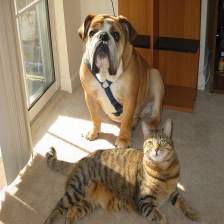

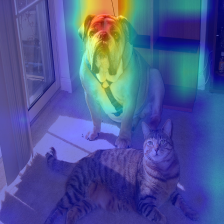

True

In [ ]:
from google.colab.patches import cv2_imshow
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2_imshow(np_img)
cv2_imshow(mask)
cv2.imwrite("input.png", np_img)
#cv2.imwrite(name, mask)

In [ ]:
for i, data in enumerate(train_loader):
  inputs = data['images']
  labels = torch.squeeze(data['labels'])
  print(labels)
  break

tensor([800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
        800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800,
        800, 800, 800, 800])


In [ ]:
#utils ( probably for attention maps)
import torch.nn.functional as F
import torch.nn as nn
def at(x):
    return F.normalize(torch.tensor(x).pow(2).mean(1).view(x.size(0), -1))


def at_loss(x, y):
    return (at(x) - at(y)).pow(2).mean()

In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(model_s.parameters(), lr=0.001, momentum=0.1)
model_s.to(device)
model_t.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

In [ ]:
def myCustomLoss(y_s,y_t,labels,m_s,m_t,alpha=0,beta=0):
  ce_loss = torch.nn.CrossEntropyLoss()
  kl_loss=torch.nn.KLDivLoss(reduction = 'batchmean')

  p = torch.nn.functional.log_softmax(y_s, dim=1)
  q = torch.nn.functional.log_softmax(y_t.detach(), dim=1)

  kl = kl_loss(p, q)
  ce = ce_loss(y_s,labels)
  loss = torch.nn.MSELoss()
  soft_loss =  kl * alpha + ce * (1. - alpha)

  at = loss(m_s,m_t.detach())

  total_loss = soft_loss + beta*at

  return total_loss

In [ ]:
def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            '''
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total'''
            _, predicted = torch.max(y_s.data, 1)
            total += 1
            if (predicted == labels):
              correct+=1
            accuracy = 100 * correct / total

            if i % 10 == 0:

              print('Finished Testing')
              print('Testing accuracy: %.1f %%' %(accuracy))
              break

In [ ]:
def train_model(loader, test_loader, epochs = 1):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0
        try:
          for i, data in enumerate(loader):

              # get the inputs; data is a list of [inputs, labels]
              inputs = data['images']
              labels = torch.squeeze(data['labels'])
              #print(labels)
              inputs = inputs.to(device)
              labels = labels.to(device)
              print(labels)
              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              attention_rollout_s = VITAttentionRollout(model_s, head_fusion='max', discard_ratio=0.9)
              m_s,y_s = attention_rollout_s(inputs)
              with torch.no_grad():
                attention_rollout_t = VITAttentionRollout(model_t, head_fusion='max', discard_ratio=0.9)
                m_t,y_t = attention_rollout_t(inputs)
              '''
              y_s = model_s(inputs)
              with torch.no_grad():
                y_t = model_t(inputs)'''
              loss = myCustomLoss(y_s,y_t,m_s,m_t,labels,0.5,0.5)
              loss.backward()
              optimizer.step()

              _, predicted = torch.max(y_s.data, 1)
              total += 1
              if (predicted == labels):
                correct+=1
              accuracy = 100 * correct / total

              # Print performance statistics
              running_loss += loss.item()
              if i % 10 == 0:    # print every 10 batches
                  batch_time = time.time()
                  speed = (i+1)/(batch_time-start_time)
                  print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                        (epoch + 1, i, running_loss, speed, accuracy))

                  running_loss = 0.0
                  print('Testing Model Performance')
                  test_model(test_loader,model_s)
              torch.cuda.empty_cache()
        except Exception as e:
          continue

    print('Finished Training')




In [ ]:
train_model(train_loader,test_loader,200)

tensor([205, 205, 205, 205], device='cuda:0')
tensor([558, 558, 558, 558], device='cuda:0')
tensor([130, 130, 130, 130], device='cuda:0')
tensor([915, 915, 915, 915], device='cuda:0')
tensor([180, 180, 180, 180], device='cuda:0')
tensor([170, 170, 170, 170], device='cuda:0')
tensor([339, 339, 339, 339], device='cuda:0')
tensor([59, 59, 59, 59], device='cuda:0')
tensor([267, 267, 267, 267], device='cuda:0')
tensor([873, 873, 873, 873], device='cuda:0')
tensor([656, 656, 656, 656], device='cuda:0')
tensor([471, 471, 471, 471], device='cuda:0')
tensor([521, 521, 521, 521], device='cuda:0')
